In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ddc import DataLorenz96

In [2]:
import sys
sys.path.append("..")
from esnpy import ESN, from_zarr

In [3]:
data = DataLorenz96(system_dimension=6)

In [4]:
esn = ESN(
    n_input=data.system_dimension,
    n_output=data.system_dimension,
    n_reservoir=500,
    input_factor=0.863,
    adjacency_factor=0.713,
    connectedness=5,
    bias=1.76,
    leak_rate=0.874,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "normalization": "svd",
    },
    random_seed=0,
)

In [5]:
esn

ESN
    n_input:                6
    n_output:               6
    n_reservoir:            500
--- 
    connectedness:          5
    bias:                   1.76
    leak_rate:              0.874
    tikhonov_parameter:     6.9e-07
--- 
    random_seed:            0
    random_state:           RandomState(MT19937)
--- 
    Input Matrix:
        factor              0.863
        distribution        uniform
        normalization       svd
        is_sparse           False
--- 
    Adjacency Matrix:
        factor              0.713
        density             0.01
        distribution        uniform
        normalization       eig
        is_sparse           True
        format              csr

In [6]:
esn.build()

In [7]:
data.generate(n_steps=42_000)

In [8]:
%timeit esn.train(data.values, batch_size=5_000)

1.08 s ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
data.generate(n_steps=1_000)
data.generate(n_steps=1_501)

In [10]:
y = esn.predict(data.values, n_steps=1_000, n_spinup=500)

In [11]:
u = data.values[:, 500:]

In [12]:
time = data.delta_t*np.arange(y.shape[-1])

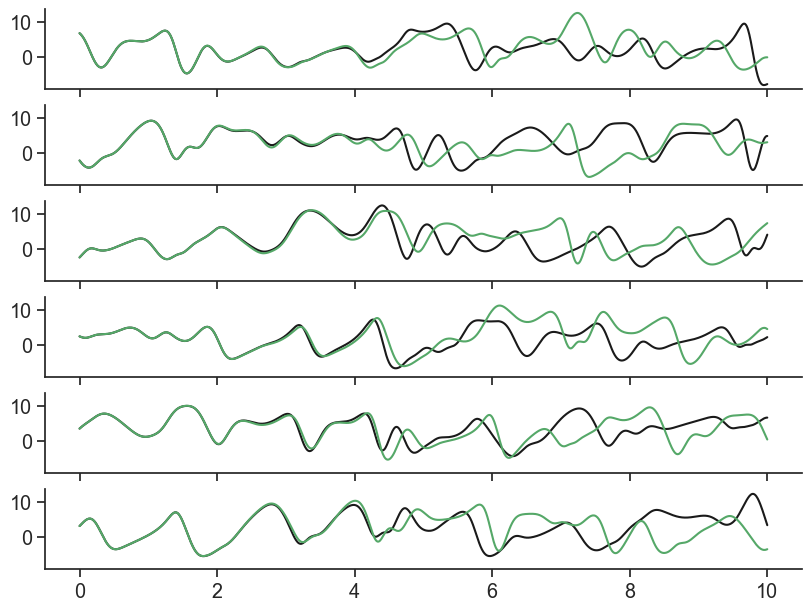

In [13]:
nrows = data.system_dimension
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for ui, yi, ax in zip(u, y, axs):
    ax.plot(time, ui, color='k')
    ax.plot(time, yi, color="C2")
    for key in ["top", "right"]:
        ax.spines[key].set_visible(False)

## Save and re-load

In [14]:
ds = esn.to_xds()
ds.to_zarr("test.zarr")

In [15]:
esn2 = from_zarr("test.zarr")

In [16]:
y2 = esn2.predict(data.values, n_steps=1_000, n_spinup=500)

In [17]:
np.abs(y-y2).max()

3.883831789508463e-08

In [18]:
from shutil import rmtree

In [19]:
rmtree("test.zarr")